In [ ]:
  ## DATA OVERVIEW

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

# Load dataset
cc_apps = pd.read_csv("/content/cc_approvals.data", header=None)
cc_apps.rename(columns = {0:'Gender', 1:'Age', 2:'Debt', 3:'Married', 4:'Bank Customer', 5:'Education Level', 6:'Ethnicity', 7:'Years Employed', 
                          8:'Prior Default', 9:'Employed', 10:'Credit Score', 11:'DL', 12:'Citizen', 13:'Zipcode', 14:'Income', 15:'Approval Status'}, inplace=True)

# Descriptive statistics
cc_apps_description = cc_apps.describe()
cc_apps_info = cc_apps.info()
print(cc_apps_info, '\n', cc_apps_description)

# Drop the features 11 and 13
cc_apps = cc_apps.drop(['DL', 'Zipcode'], axis=1)

print('\n', cc_apps.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           690 non-null    object 
 1   Age              690 non-null    object 
 2   Debt             690 non-null    float64
 3   Married          690 non-null    object 
 4   Bank Customer    690 non-null    object 
 5   Education Level  690 non-null    object 
 6   Ethnicity        690 non-null    object 
 7   Years Employed   690 non-null    float64
 8   Prior Default    690 non-null    object 
 9   Employed         690 non-null    object 
 10  Credit Score     690 non-null    int64  
 11  DL               690 non-null    object 
 12  Citizen          690 non-null    object 
 13  Zipcode          690 non-null    object 
 14  Income           690 non-null    int64  
 15  Approval Status  690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB
Non

In [ ]:
## DATA CLEANING

# Recoding features
cc_apps['Approval Status'] = cc_apps['Approval Status'].replace(['+', '-'], [1, 0])
cc_apps['Gender'] = cc_apps['Gender'].replace(['a', 'b'], ['Male', 'Female'])
cc_apps['Prior Default'] = cc_apps['Prior Default'].replace(['f', 't'], ['No', 'Yes'])
cc_apps['Employed'] = cc_apps['Employed'].replace(['t', 'f'], ['Yes', 'No'])
cc_apps['Married'] = cc_apps['Married'].replace('l', 'y')
cc_apps['Married'] = cc_apps['Married'].replace(['y', 'u'], ['Yes', 'No'])
cc_apps['Age'] = cc_apps['Age'].replace('?', 'NaN')
cc_apps['Age'] = cc_apps['Age'].astype('float64')

# Clean up missing values from numerical features
cc_apps = cc_apps.replace('?', 'NaN')
cc_apps.fillna(cc_apps.mean(), inplace=True)
print(cc_apps.isna().sum())

# Clean up missing values from categorical features
for col in cc_apps.columns:
    if cc_apps[col].dtypes == 'object':
        # Impute with the most frequent value
        cc_apps = cc_apps.fillna(cc_apps[col].value_counts().index[0])
# Impute with the most frequent value
cc_apps['Married'] = cc_apps['Married'].replace('NaN', 'No')
cc_apps['Gender'] = cc_apps['Gender'].replace('NaN', 'Female')


Gender             0
Age                0
Debt               0
Married            0
Bank Customer      0
Education Level    0
Ethnicity          0
Years Employed     0
Prior Default      0
Employed           0
Credit Score       0
Citizen            0
Income             0
Approval Status    0
dtype: int64


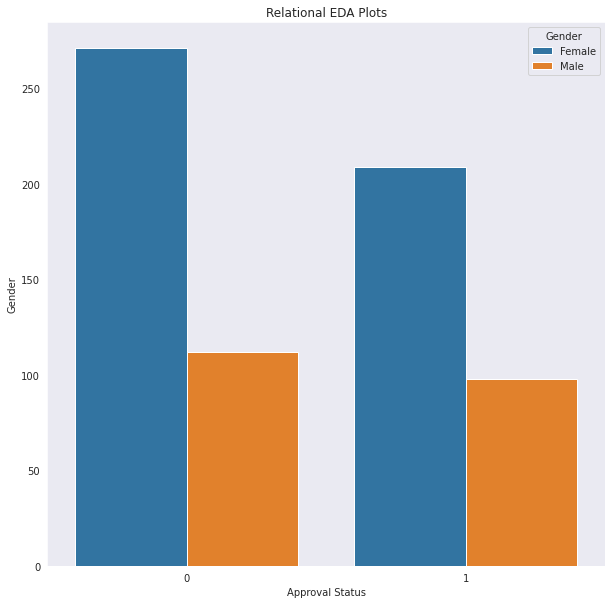

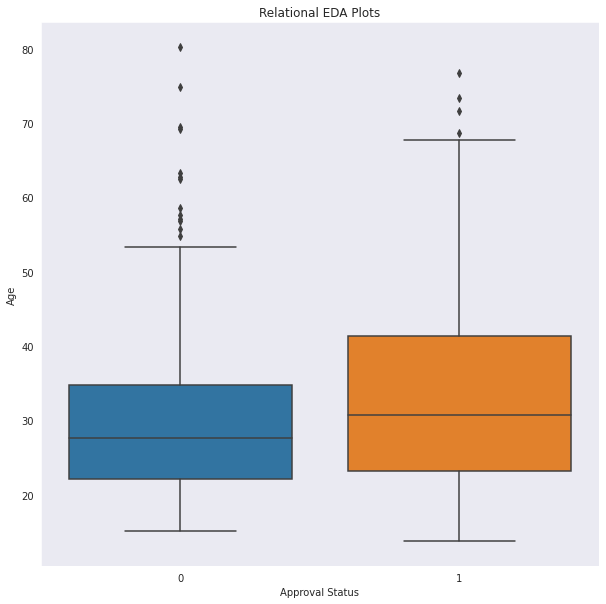

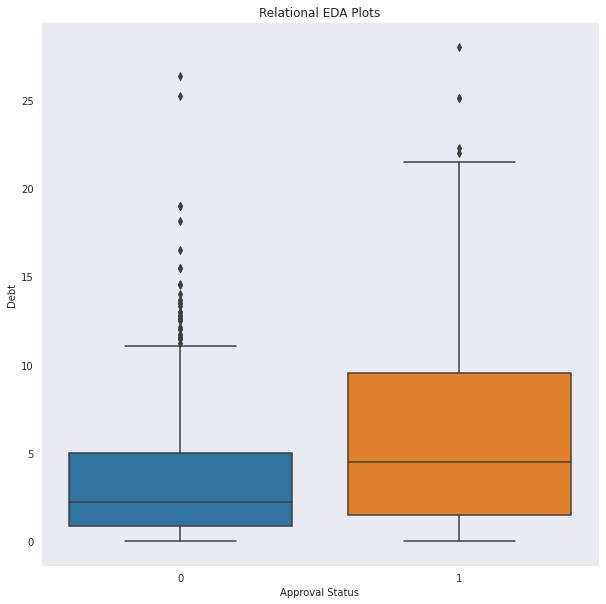

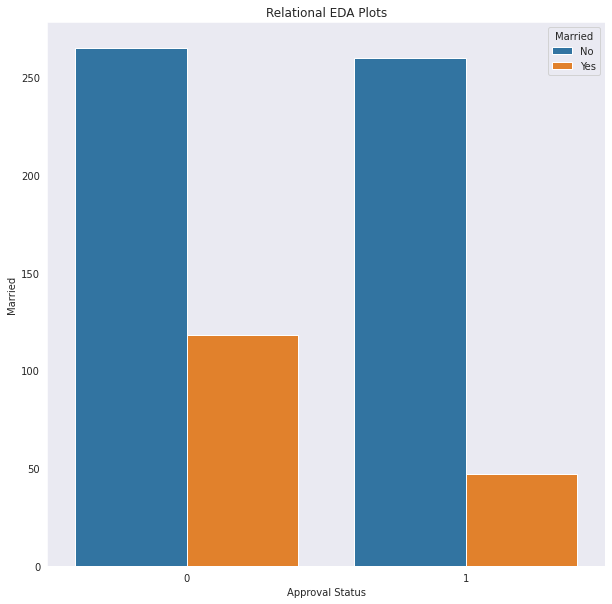

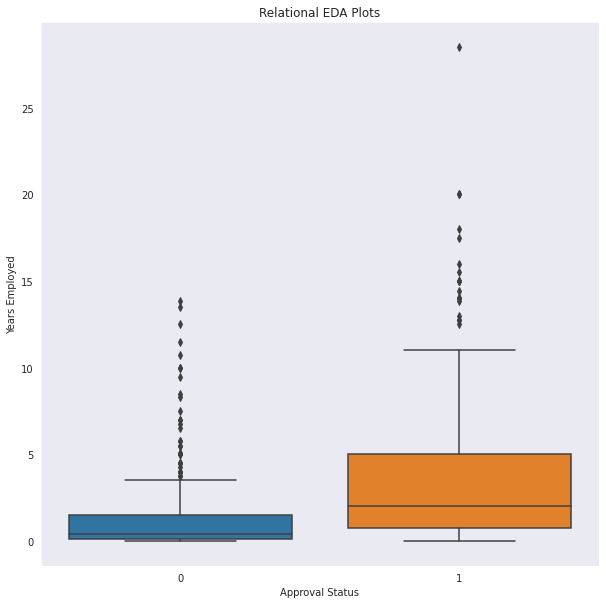

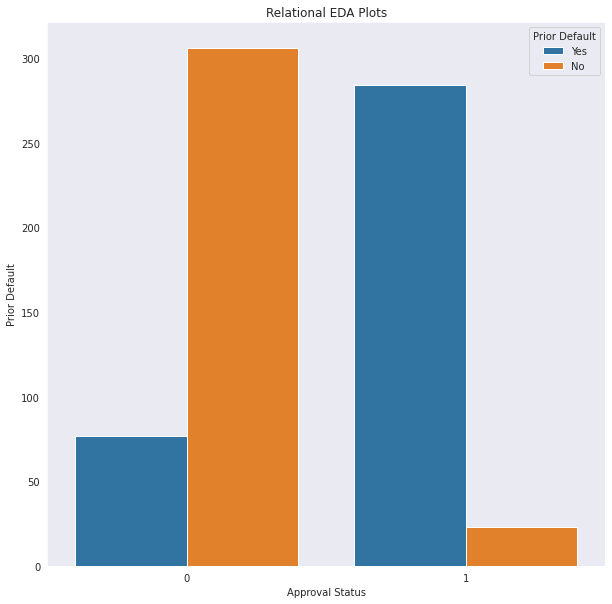

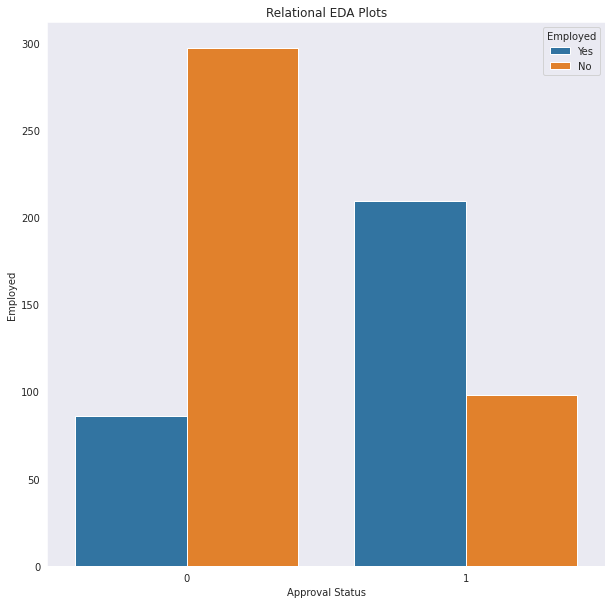

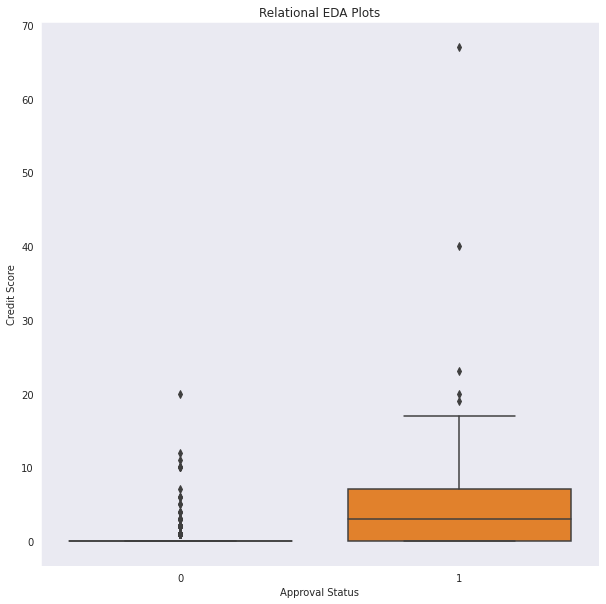

Text(0.5, 1.0, 'Relational EDA Plots')

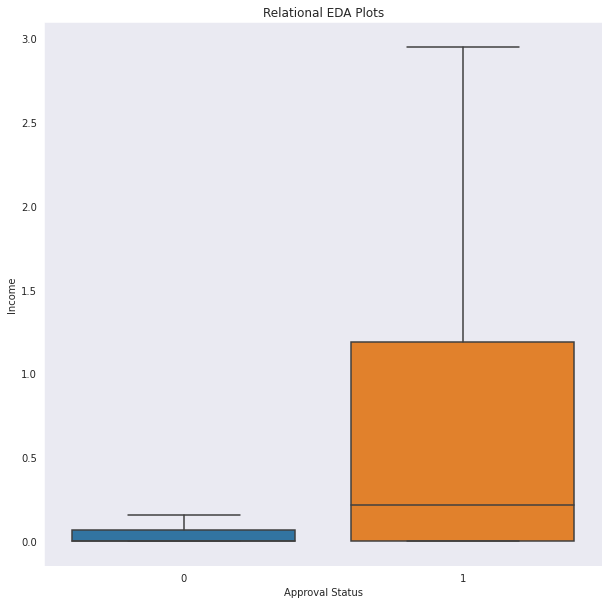

In [ ]:
## EDA VISUALIZATIONS

sns.set_style('dark')

# Plotting Function
def plots(df, col):
  if df[col].dtypes == 'int64' or df[col].dtypes == 'float64':
    plt.figure(figsize=(10,10))
    g = sns.boxplot('Approval Status', col, data=df)
  else:
    plt.figure(figsize=(10,10))
    g = sns.countplot('Approval Status', hue=col, data=df)
  plt.xlabel('Approval Status')
  plt.ylabel(col)
  plt.title('Relational EDA Plots')
  plt.show()

# Plots
columns = cc_apps.columns
columns = ['Gender', 'Age', 'Debt', 'Married', 'Years Employed', 'Prior Default', 
           'Employed', 'Credit Score']
for col in columns:
  plots(cc_apps, col)

# Income Plot after standardization
income = cc_apps['Income']
income = income/np.mean(income)
target = cc_apps['Approval Status']
plt.figure(figsize=(10,10))
sns.boxplot(target, income, showfliers=False)
plt.title('Relational EDA Plots')


Accuracy of logistic regression classifier:  0.9868421052631579
[[204   1]
 [  2  21]] = Confusion Matrix


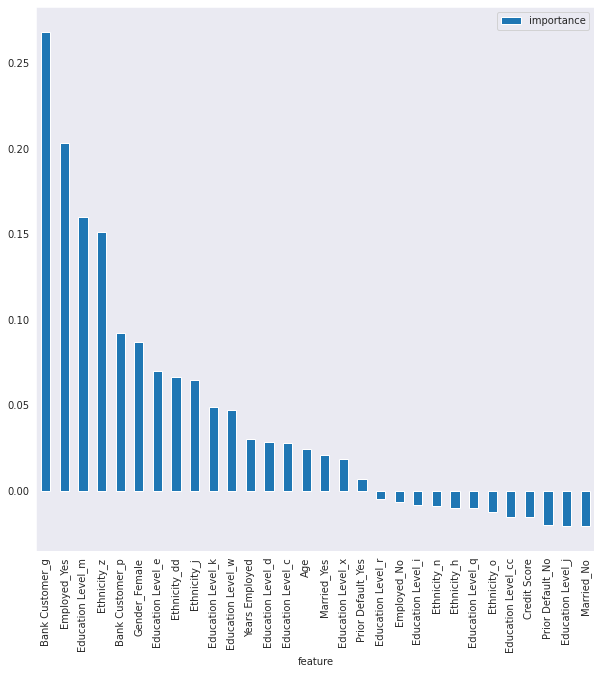

In [ ]:
## MODEL

# Split the dataset
cc_apps_train, cc_apps_test = train_test_split(cc_apps, test_size=0.33, random_state=42)

# Convert the categorical features in the train and test sets independently
cc_apps_train = pd.get_dummies(cc_apps_train)
cc_apps_test = pd.get_dummies(cc_apps_test)
# Reindex the columns of the test set aligning with the train set
cc_apps_test = cc_apps_test.reindex(columns=cc_apps_train.columns, fill_value=0)

# Segregate features and labels into separate variables
X_train, y_train = cc_apps_train.iloc[:, :-1].values, cc_apps_train.iloc[:, [-1]].values
X_test, y_test = cc_apps_test.iloc[:, :-1].values, cc_apps_test.iloc[:, [-1]].values

# Rescaling features
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

# LogisticRegression classifier with default parameter values
logreg = LogisticRegression()
logreg.fit(rescaledX_train, y_train)
y_pred = logreg.predict(rescaledX_test)

# Evaluation Metrics
print("Accuracy of logistic regression classifier: ", logreg.score(rescaledX_test, y_test))
print(confusion_matrix(y_test, y_pred), '= Confusion Matrix')

#Feature Importance
coefficients = np.std(rescaledX_train)*logreg.coef_[0]
coefficients = coefficients.flatten()
features = cc_apps_train.columns
features = features.drop('Ethnicity_NaN')
feature_importances = pd.DataFrame({'feature':features, 'importance':coefficients})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances.set_index('feature', inplace=True)
feature_importances[:30].plot.bar(figsize=(10,10))
plt.show()


In [ ]:
## HYPERPARAMETER TUNING

# Define the grid of hyperparameter values
tol = [0.01, 0.001, 0.0001]
max_iter = [100, 150, 200]
param_grid = dict(tol=tol, max_iter=max_iter)

# Instantiate GridSearchCV
grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)
grid_model_result = grid_model.fit(rescaledX_train, y_train)

# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

# Extract the best model and evaluate it on the test set
best_model = grid_model_result.best_estimator_
print("Accuracy of the best specification of the logistic regression classifier: ", best_model.score(rescaledX_test, y_test))

Best: 0.993548 using {'max_iter': 100, 'tol': 0.01}
Accuracy of the best specification of the logistic regression classifier:  0.9868421052631579
